In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
%matplotlib inline

In [2]:
# 定义超参数 
image_size = 28  #图像的总尺寸28*28
num_classes = 10  #标签的种类数
num_epochs = 20  #训练的总循环周期
batch_size = 64  #一个撮（批次）的大小，64张图片
# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中
# MNIST数据是属于torchvision包自带的数据，所以可以直接调用。
# 在调用自己的数据的时候，我们可以用torchvision.datasets.ImageFolder或者torch.utils.data.TensorDataset来加载
train_dataset = dsets.MNIST(root='/home/retoo/Desktop/实验/数据集/3.深度学习/7data/MNIST', download=True, #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor()) 
#当找不到文件的时候，自动下载 ；将图像转化为Tensor，在加载数据的时候，就可以对图像做预处理
# 加载测试数据集
test_dataset = dsets.MNIST(root='/home/retoo/Desktop/实验/数据集/3.深度学习/7data/MNIST', download=True,
                           train=False, 
                           transform=transforms.ToTensor())
# 训练数据集的加载器，自动将数据分割成batch，顺序随机打乱
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
'''我们希望将测试数据分成两部分，一部分作为校验数据，一部分作为测试数据。
校验数据用于检测模型是否过拟合，并调整参数，测试数据检验整个模型的工作'''
# 首先，我们定义下标数组indices，它相当于对所有test_dataset中数据的编码
# 然后定义下标indices_val来表示校验集数据的那些下标，indices_test表示测试集的下标
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]
# 根据这些下标，构造两个数据集的SubsetRandomSampler采样器，它会对下标进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)
# 根据两个采样器来定义加载器，注意将sampler_val和sampler_test分别赋值给了validation_loader和test_loader
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val
                                               )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          sampler = sampler_test
                                         )

标签是： 0


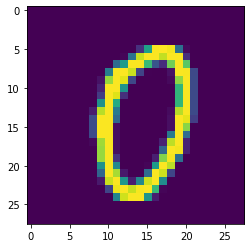

In [3]:
#随便从数据集中读入一张图片，并绘制出来
idx = 1000
#dataset支持下标索引，其中提取出来的每一个元素为features，target格式，即属性和标签。[0]表示索引features
muteimg = train_dataset[idx][0].numpy()
#由于一般的图像包含rgb三个通道，而MINST数据集的图像都是灰度的，只有一个通道。因此，我们忽略通道，把图像看作一个灰度矩阵。
#用imshow画图，会将灰度矩阵自动展现为彩色，不同灰度对应不同颜色：从黄到紫
plt.imshow(muteimg[0,...])
print('标签是：',train_dataset[idx][1])

In [4]:
#定义卷积神经网络：4和8为人为指定的两个卷积层的厚度（feature map的数量）
depth = [4, 8]
class ConvNet(nn.Module):
    def __init__(self):
        # 该函数在创建一个ConvNet对象的时候，即调用如下语句：net=ConvNet()，就会被调用
        # 首先调用父类相应的构造函数
        super(ConvNet, self).__init__()
        # 其次构造ConvNet需要用到的各个神经模块。
        '''注意，定义组件并没有真正搭建这些组件，只是把基本建筑砖块先找好'''
        self.conv1 = nn.Conv2d(1, 4, 5, padding = 2) #定义一个卷积层，输入通道为1，输出通道为4，窗口大小为5，padding为2
        self.pool = nn.MaxPool2d(2, 2) #定义一个Pooling层，一个窗口为2*2的pooling运算
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) #第二层卷积，输入通道为depth[0], 
                                                                   #输出通道为depth[1]，窗口为5，padding为2
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1] , 512) 
                                                            #一个线性连接层，输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为512，输出为要做分类的类别数
    def forward(self, x):
        #该函数完成神经网络真正的前向运算，我们会在这里把各个组件进行实际的拼装
        #x的尺寸：(batch_size, image_channels, image_width, image_height)
        x = F.relu(self.conv1(x))  #第一层卷积，激活函数用ReLu，为了防止过拟合
        #x的尺寸：(batch_size, num_filters, image_width, image_height)
        x = self.pool(x) #第二层pooling，将图片变小
        #x的尺寸：(batch_size, depth[0], image_width/2, image_height/2)
        x = F.relu(self.conv2(x)) #第三层又是卷积，窗口为5，输入输出通道分别为depth[0]=4, depth[1]=8
        #x的尺寸：(batch_size, depth[1], image_width/2, image_height/2)
        x = self.pool(x) #第四层pooling，将图片缩小到原大小的1/4
        #x的尺寸：(batch_size, depth[1], image_width/4, image_height/4)
        # 将立体的特征图Tensor，压成一个一维的向量
        # view这个函数可以将一个tensor按指定的方式重新排布。
        # 下面这个命令就是要让x按照batch_size * (image_size//4)^2*depth[1]的方式来排布向量
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        #x的尺寸：(batch_size, depth[1]*image_width/4*image_height/4)
        x = F.relu(self.fc1(x)) #第五层为全链接，ReLu激活函数
        #x的尺寸：(batch_size, 512)
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作，为了防止过拟合
        x = self.fc2(x) #全链接
        #x的尺寸：(batch_size, num_classes)
        x = F.log_softmax(x, dim = 0) #输出层为log_softmax，即概率对数值log(p(x))。采用log_softmax可以使得后面的交叉熵计算更快
        return x
    def retrieve_features(self, x):
        #该函数专门用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)

In [ ]:
net = ConvNet()  # 新建一个卷积神经网络的实例，此时ConvNet的__init__函数就会被自动调用

criterion = nn.CrossEntropyLoss()  # Loss函数的定义，交叉熵
# optimizer = optim.Adam(net.parameters(), lr=0.001,betas=(0.9, 0.99)) #定义优化器
# optimizer = optim.SGD(net.parameters(),lr=0.001, momentum=0.9)
optimzier = torch.optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9)
# optimzier= torch.optim.SGD(net_SGD.parameters(), lr=0.001)
record = []  # 记录准确率等数值的容器
weights = []  # 每若干步就记录一次卷积核

def rightness(output, target):
    pred=output.data.max(dim=1,keepdim=True)[1]
    return  pred.eq(target.data.view_as(pred)).cpu().sum(),len(target)

# 开始训练循环
for epoch in range(num_epochs):

    train_rights = []  # 记录训练数据集准确率的容器

    ''' 下面的enumerate是构造一个枚举器的作用。就是我们在对train_loader做循环迭代的时候，enumerate会自动吐出一个数字指示我们循环了几次
     这个数字就被记录在了batch_idx之中，它就等于0，1.txt，2，……
     train_loader每迭代一次，就会吐出来一对数据data和target，分别对应着一个batch中的手写数字图，以及对应的标签。'''

    for batch_idx, (data, target) in enumerate(train_loader):  # 针对容器中的每一个批进行循环
        data, target = data.clone().requires_grad_(True), target.clone().detach()
        # data为一批图像，target为一批标签
        #x.data（x.detach()） 返回和 x 的相同数据 tensor, 这个新的tensor和原来的tensor（即x）是共用数据的，一者改变，另一者也会跟着改变，且require s_grad = False
        #不同点： x.data 不能被 autograd 追踪求微分，即使被改了也能错误求导，而x.detach()则不行
        net.train()  # 给网络模型做标记，标志说模型正在训练集上训练，
        # 这种区分主要是为了打开关闭net的training标志，从而决定是否运行dropout

        output = net(data)  # 神经网络完成一次前馈的计算过程，得到预测输出output
        loss = criterion(output, target)  # 将output与标签target比较，计算误差
        optimzier.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimzier.step()  # 一步随机梯度下降算法
        right = rightness(output, target)  # 计算准确率所需数值，返回数值为（正确样例数，总样本数）
        train_rights.append(right)  # 将计算结果装到列表容器train_rights中

        if batch_idx % 100 == 0:  # 每间隔100个batch执行一次打印等操作

            net.eval()  # 给网络模型做标记，标志说模型在训练集上训练
            val_rights = []  # 记录校验数据集准确率的容器

            '''开始在校验数据集上做循环，计算校验集上面的准确度'''
            for (data, target) in validation_loader:
                data, target = data.clone().requires_grad_(True), target.clone().detach()
                output = net(data)  # 完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                right = rightness(output, target)  # 计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_rights.append(right)

            # 分别计算在目前已经计算过的测试数据集，以及全部校验集上模型的表现：分类准确率
            # train_r为一个二元组，分别记录目前已经经历过的所有训练集中分类正确的数量和该集合中总的样本数，
            # train_r[0]/train_r[1.txt]就是训练集的分类准确度，同样，val_r[0]/val_r[1.txt]就是校验集上的分类准确度
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            # val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            # 打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前撮的正确率的平均值
            print(val_r)
            print('训练周期: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t训练正确率: {:.2f}%\t校验正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                loss.data,
                       100. * train_r[0].numpy() / train_r[1],
                       100. * val_r[0].numpy() / val_r[1]))

            # 将准确率和权重等数值加载到容器中，以方便后续处理
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1]))
            # weights记录了训练周期中所有卷积核的演化过程。net.conv1.weight就提取出了第一层卷积核的权重
            # clone的意思就是将weight.data中的数据做一个拷贝放到列表中，否则当weight.data变化的时候，列表中的每一项数值也会联动
            '''这里使用clone这个函数很重要'''
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(),
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])


# 绘制实验结果，打印测试集上的准确度
plt.plot([i[0] for i in record],label='Train')
plt.plot([i[1] for i in record],label='Validation')
# right_rate
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Error Rate')

(tensor(1565), 5000)
训练周期: 0 [0/60000 (0%)]	Loss: 2.298913	训练正确率: 18.75%	校验正确率: 31.30%
